In [1]:
!pip install torch
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
# Extract subgraph around a given node
def extract_subgraph(data, node_idx, k=2):
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, k, data.edge_index, num_nodes=data.x.size(0), relabel_nodes=True, directed=True)
    # subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, k, data.edge_index, num_nodes=data.x.size(0), flow="target_to_source" , relabel_nodes=False, directed=True)
    sub_x = data.x[subset]
    sub_data = Data(x=sub_x, edge_index=edge_index)
    return sub_data


# Find a subgraph that contains a cycle
def find_cycle_subgraph(data):
    G = nx.DiGraph()
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)
    try:
        cycle = nx.find_cycle(G, orientation='original')
        cycle_nodes = set(node for edge in cycle for node in edge[:2])
        sub_edges = [edge for edge in edge_list if edge[0] in cycle_nodes and edge[1] in cycle_nodes]
        sub_edge_index = torch.tensor(sub_edges, dtype=torch.long).t().contiguous()
        sub_x = data.x[list(cycle_nodes)]
        return Data(x=sub_x, edge_index=sub_edge_index, y=torch.tensor([1], dtype=torch.long))
    except nx.NetworkXNoCycle:
        print("No cycle found in the graph.")
        return None

# Analyze subgraph for fraud
def analyze_subgraph(model, data, node_idx, k=2):
    sub_data = extract_subgraph(data, node_idx, k)
    model.eval()
    with torch.no_grad():
        output = model(sub_data.x, sub_data.edge_index, torch.zeros(sub_data.x.shape[0], dtype=torch.long))
        pred = output.argmax(dim=1).item()
        print(f"Fraud Prediction for Node {node_idx}: {'Fraud' if pred == 1 else 'Not Fraud'}")
        sub_data_with_y = Data(x=sub_data.x, edge_index=sub_data.edge_index, y=output.argmax(dim=1))
        visualize_graph(sub_data_with_y)

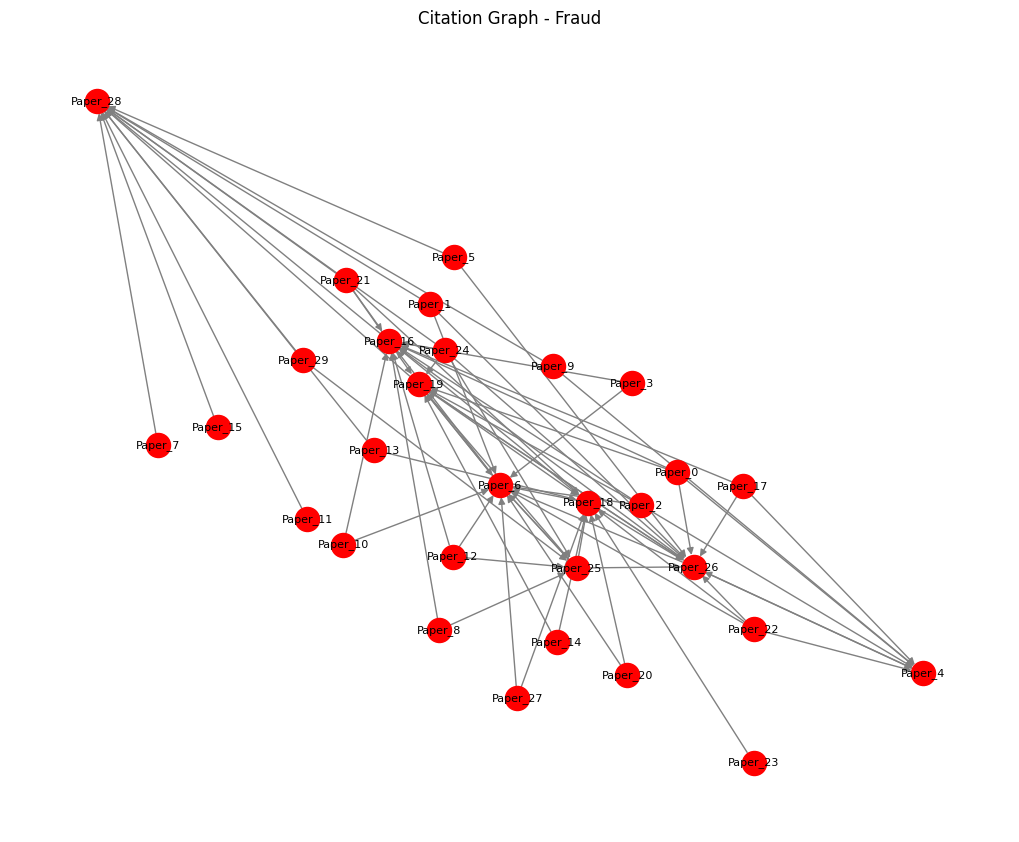

Paper_0 ['Author_29', 'Author_44']
Paper_1 ['Author_35', 'Author_34', 'Author_24']
Paper_2 ['Author_1', 'Author_16']
Paper_3 ['Author_38']
Paper_4 ['Author_2', 'Author_43']
Paper_5 ['Author_25', 'Author_17']
Paper_6 ['Author_7', 'Author_27']
Paper_7 ['Author_3', 'Author_23', 'Author_5']
Paper_8 ['Author_4', 'Author_27']
Paper_9 ['Author_35', 'Author_37']
Paper_10 ['Author_30', 'Author_26', 'Author_31']
Paper_11 ['Author_38', 'Author_2', 'Author_39']
Paper_12 ['Author_39', 'Author_49', 'Author_50']
Paper_13 ['Author_46']
Paper_14 ['Author_50']
Paper_15 ['Author_8']
Paper_16 ['Author_50']
Paper_17 ['Author_27', 'Author_25', 'Author_14']
Paper_18 ['Author_16', 'Author_45', 'Author_12']
Paper_19 ['Author_5', 'Author_31']
Paper_20 ['Author_18']
Paper_21 ['Author_2']
Paper_22 ['Author_29', 'Author_37', 'Author_14']
Paper_23 ['Author_30', 'Author_32']
Paper_24 ['Author_39', 'Author_48']
Paper_25 ['Author_3']
Paper_26 ['Author_27']
Paper_27 ['Author_9', 'Author_44']
Paper_28 ['Author_30', 'Aut

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph


class CitationFraudDetector(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(CitationFraudDetector, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        return F.log_softmax(x, dim=1)

# Generate structured citation fraud data
# def generate_synthetic_data(num_nodes=100, num_edges=300, fraud_probability=0.5, num_fraud_groups=1):
def generate_synthetic_data(num_nodes=30, num_edges=90, fraud_probability=0.5, num_fraud_groups=1):

    edge_index = []
    is_fraud = random.random() < fraud_probability

    # Generate metadata for each node
    papers = []
    for i in range(num_nodes):
        authors = [f"Author_{random.randint(1, 50)}" for _ in range(random.randint(1, 3))]
        title = f"Paper_{i}"
        papers.append({"authors": authors, "title": title})

    if is_fraud:
        # Create moderately clustered citation patterns (mildly suspicious behavior)
        group_size = num_nodes // num_fraud_groups
        for g in range(num_fraud_groups):
            nodes = list(range(g * group_size, (g + 1) * group_size))
            for i in nodes:
                for j in nodes:
                    if i != j and random.random() < 0.3:  # some clustering
                        edge_index.append([i, j])
        # # Add random citations outside groups
        for _ in range(num_edges // 3):
            src, dst = random.sample(range(num_nodes), 2)
            edge_index.append([src, dst])
    else:
        # Create a more natural citation network
        for _ in range(num_edges):
            src, dst = random.sample(range(num_nodes), 2)
            edge_index.append([src, dst])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.rand((num_nodes, 16))  # Feature vector per node
    y = torch.tensor([1 if is_fraud else 0], dtype=torch.long)  # Label: 1 for fraud, 0 for normal

    initial_data = Data(x=x, edge_index=edge_index, y=y)
    # cycle_graph_data = find_cycle_subgraph(initial_data)
    # if(cycle_graph_data):
    #   visualize_graph(cycle_graph_data)

    sub_data = extract_subgraph(initial_data, round(random.random()*(num_nodes-1)))
    return Data(x=sub_data.x, edge_index=sub_data.edge_index, y=y, metadata=papers)

    # return Data(x=x, edge_index=edge_index, y=y, metadata=papers)

# Function to visualize citation graph
def visualize_graph(data):
    G = nx.DiGraph()  # Use directed graph
    edge_list = data.edge_index.t().tolist()
    G.add_edges_from(edge_list)

    labels = {i: data.metadata[i]['title'] for i in range(len(data.metadata))}

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=300, node_color='red' if data.y.item() == 1 else 'blue', edge_color='gray', arrows=True, with_labels=True, labels=labels, font_size=8)
    plt.title("Citation Graph - Fraud" if data.y.item() == 1 else "Citation Graph - Normal")
    plt.show()
    for i in range(len(data.metadata)):
      print(data.metadata[i]['title'], data.metadata[i]['authors'])

# Create dataset and DataLoader
dataset = [generate_synthetic_data() for _ in range(200)]
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Visualize one example
data_sample = dataset[0]
visualize_graph(data_sample)

# Model training loop
model = CitationFraudDetector(in_channels=16, hidden_channels=32, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    for batch in dataloader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, batch.y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [1]:
# Evaluate model accuracy
def evaluate_model(model, dataset):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataset:
            output = model(data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=torch.long))
            pred = output.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    accuracy = correct / total
    print(f"Model Accuracy: {accuracy:.4f}")

evaluate_model(model, dataset)

NameError: name 'model' is not defined

# Analyzing Sub Graph

In [91]:
# # Extract subgraph around a given node
# def extract_subgraph(data, node_idx, k=2):
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, k, data.edge_index, num_nodes=data.x.size(0), relabel_nodes=True, directed=True)
#     # subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_idx, k, data.edge_index, num_nodes=data.x.size(0), flow="target_to_source" , relabel_nodes=False, directed=True)
#     sub_x = data.x[subset]
#     print(subset)
#     print(edge_index)
#     # new_edge_index = []
#     print(mapping)
#     print(edge_mask)
#     # for(i in edge_index):
#     #   new_edge
#     sub_data = Data(x=sub_x, edge_index=edge_index)
#     # visualize_graph(sub_data)
#     return sub_data

# # Analyze subgraph for fraud
# def analyze_subgraph(model, data, node_idx, k=2):
#     sub_data = extract_subgraph(data, node_idx, k)
#     model.eval()
#     with torch.no_grad():
#         output = model(sub_data.x, sub_data.edge_index, torch.zeros(sub_data.x.shape[0], dtype=torch.long))
#         pred = output.argmax(dim=1).item()
#         print(f"Fraud Prediction for Node {node_idx}: {'Fraud' if pred == 1 else 'Not Fraud'}")
#         sub_data_with_y = Data(x=sub_data.x, edge_index=sub_data.edge_index, y=output.argmax(dim=1))
#         visualize_graph(sub_data_with_y)

tensor([0])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 0: Not Fraud


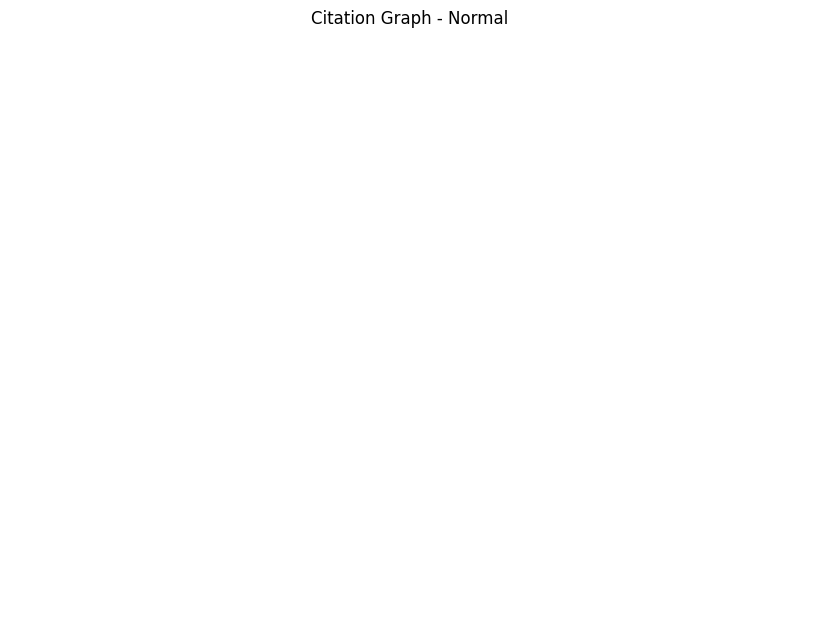

tensor([1])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 1: Not Fraud


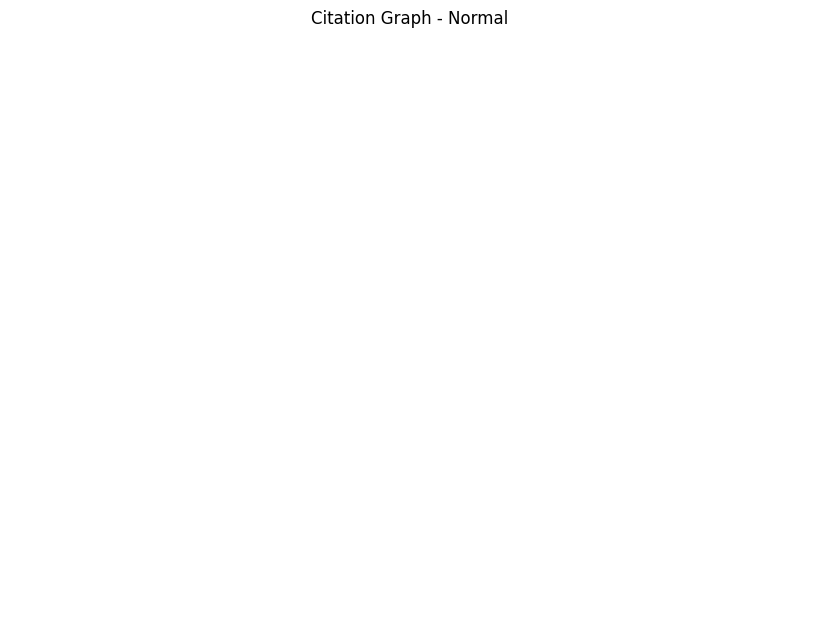

tensor([2])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 2: Fraud


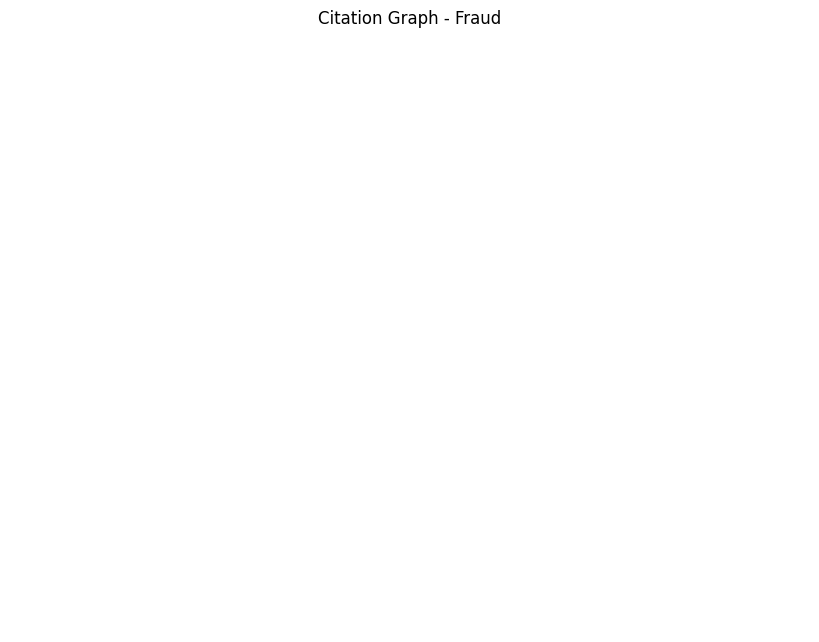

tensor([ 0,  2,  3,  5,  6,  7,  8, 11, 12, 14, 16, 18, 19, 21, 22, 25])
tensor([[ 1,  3,  5,  7,  8,  9, 10, 11, 12, 13, 15],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4]])
tensor([2])
tensor([False, False, False,  True, False, False,  True, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False,
         True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False,  True, False,  True, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False])
Fraud Prediction for Node 3: Not Fraud


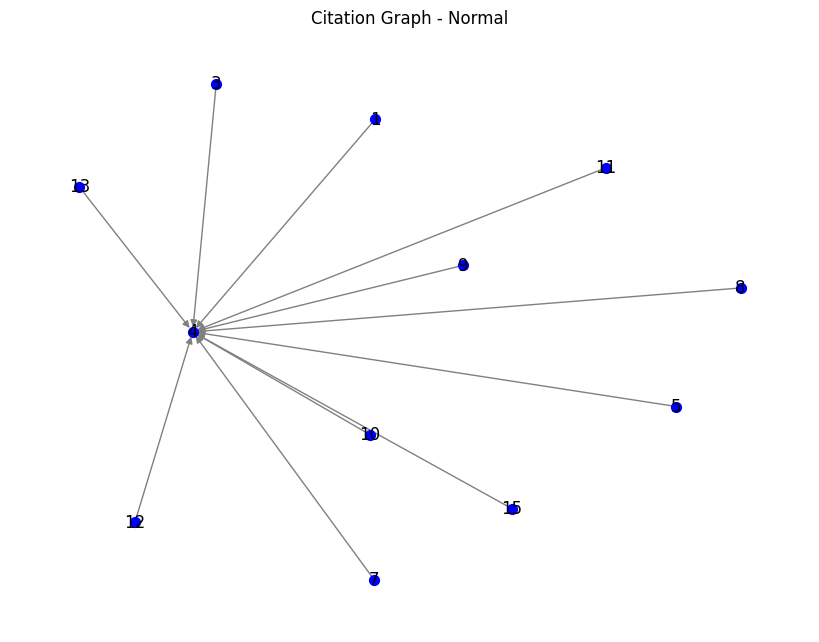

tensor([4])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 4: Fraud


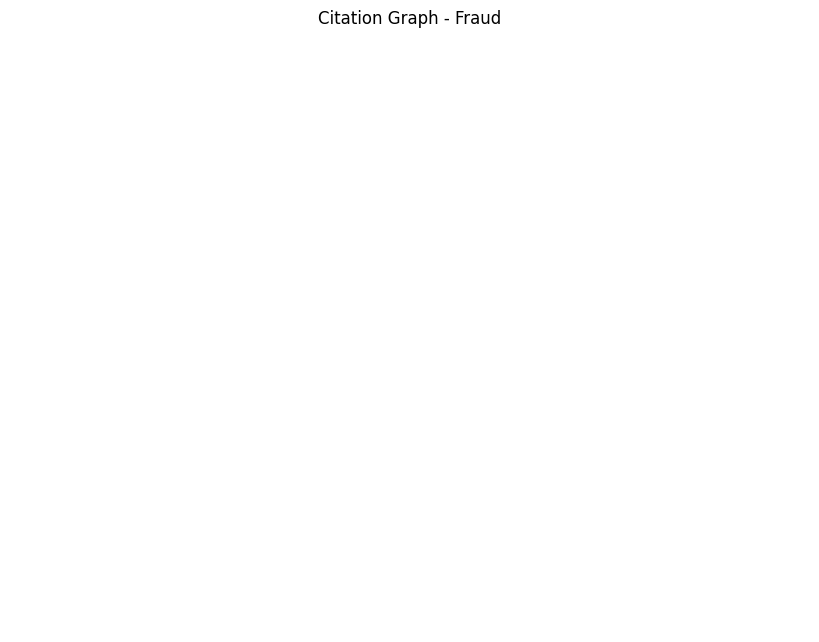

tensor([5])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 5: Fraud


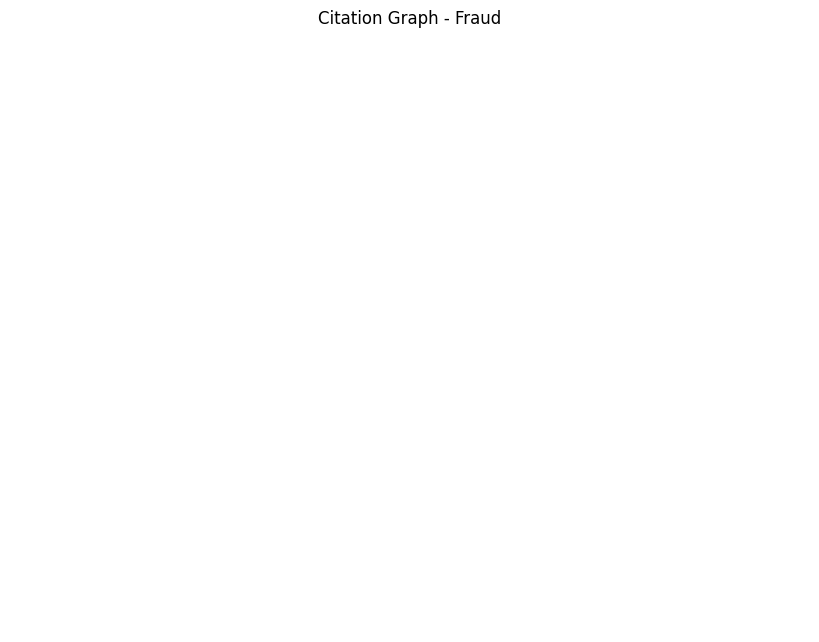

tensor([ 2,  3,  5,  6,  7,  8, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25,
        26])
tensor([[ 1,  2,  2,  5,  7,  7,  8, 11, 11, 12, 14, 16, 18, 18],
        [13, 10, 13, 10, 10, 13, 10, 10, 13, 10, 10, 10, 10, 13]])
tensor([3])
tensor([False, False, False, False,  True, False, False,  True,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True,  True,  True, False, False, False, False, False, False,
        False,  True,  True, False, False,  True, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
         True,  True])
Fraud Prediction for Node 6: Not Fraud


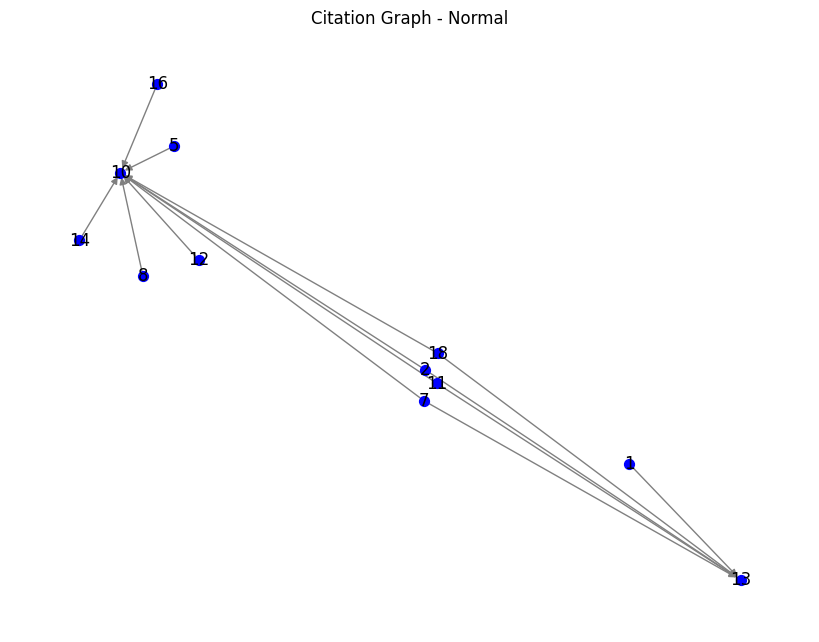

tensor([7])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 7: Not Fraud


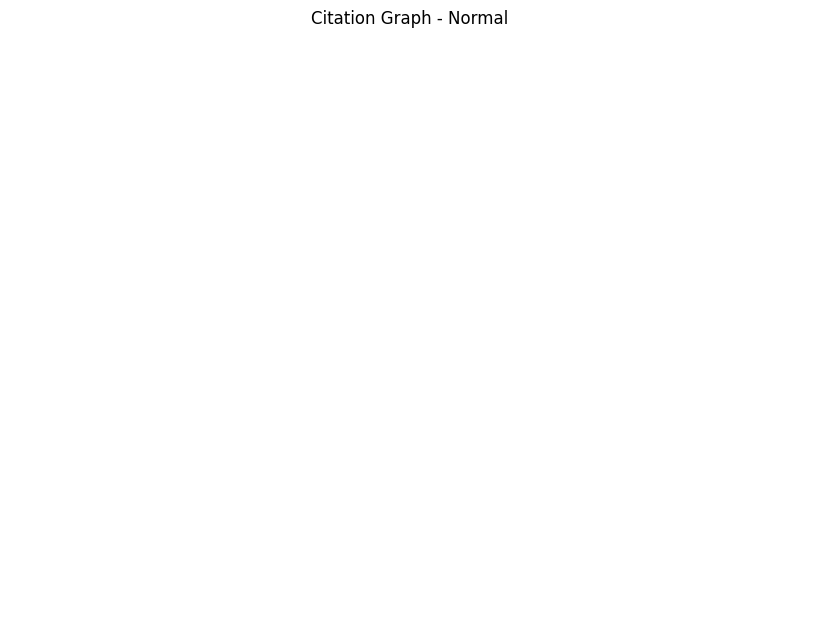

tensor([8])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 8: Not Fraud


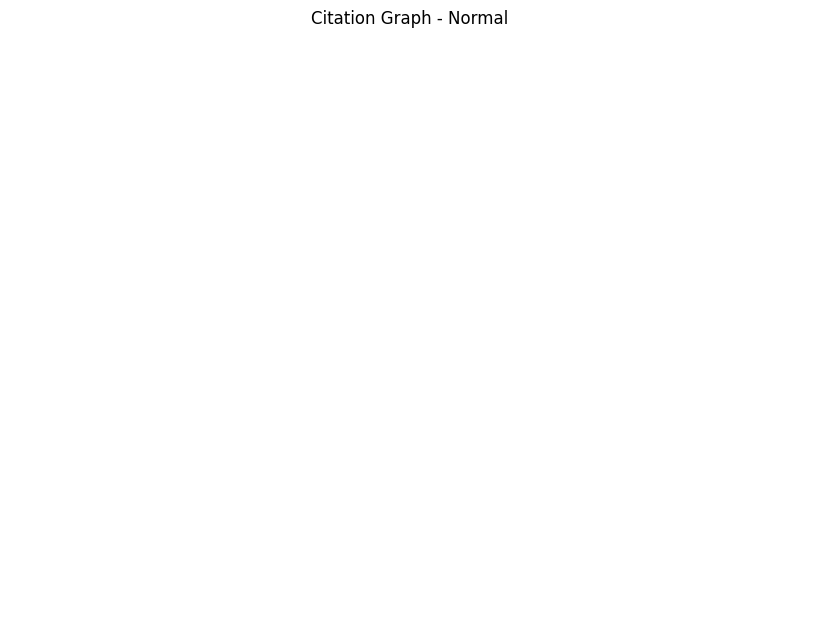

tensor([9])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 9: Not Fraud


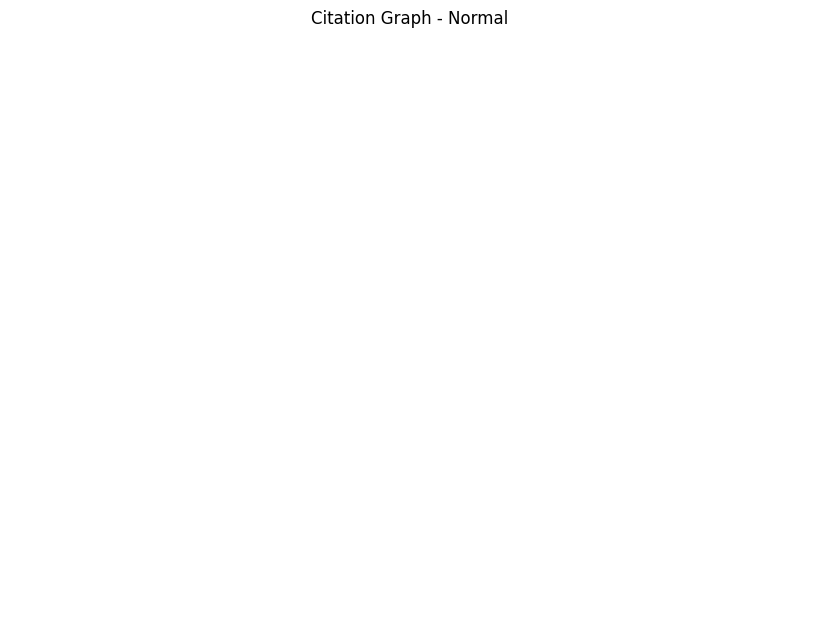

tensor([10])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 10: Not Fraud


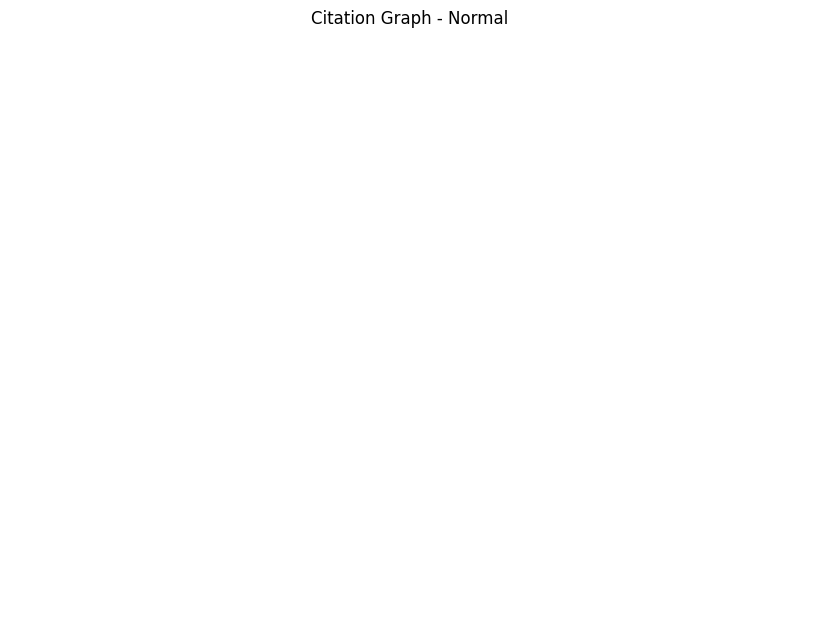

tensor([11])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 11: Fraud


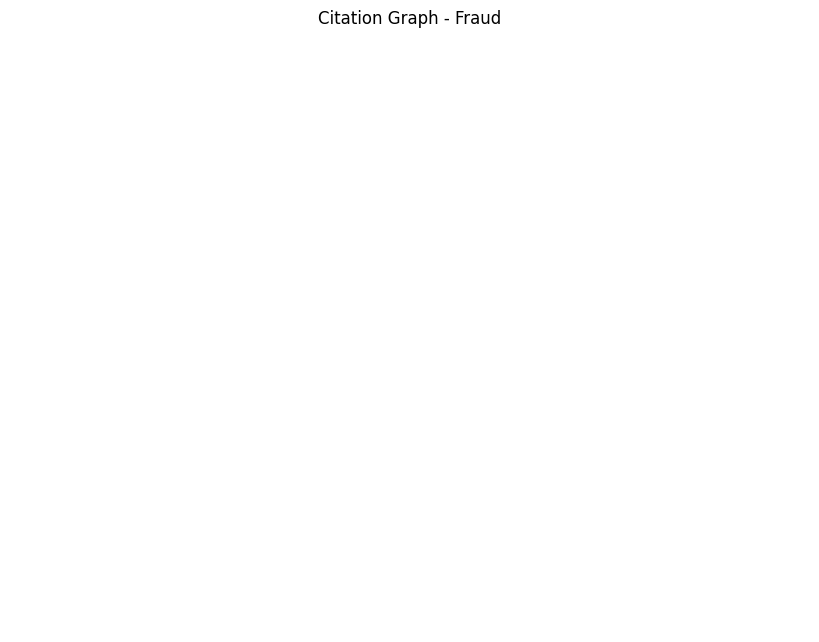

tensor([12])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 12: Fraud


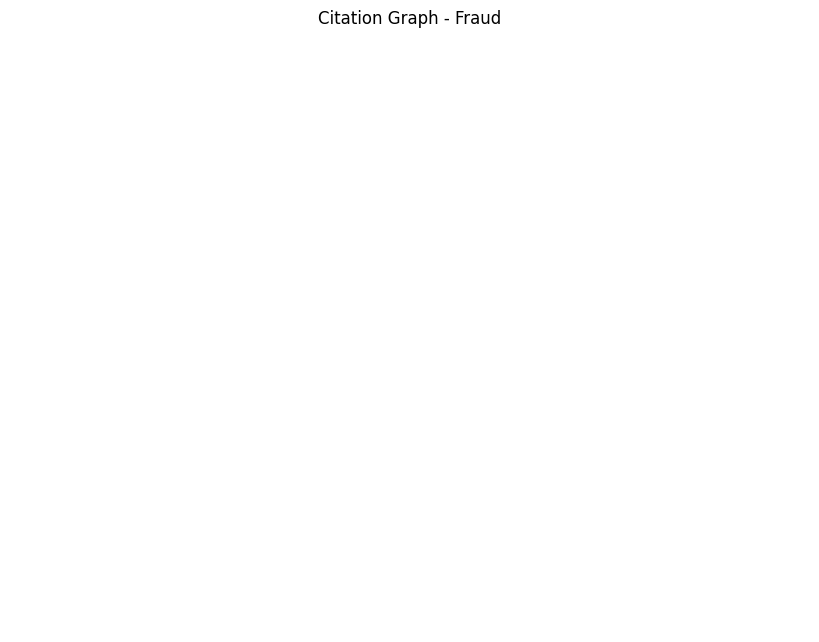

tensor([ 0,  1,  2,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23,
        24, 25])
tensor([[ 2,  3,  5,  7,  8, 10, 12, 14, 15, 16, 19],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4]])
tensor([9])
tensor([False, False, False,  True, False, False,  True, False, False, False,
        False,  True, False, False, False, False, False, False,  True, False,
         True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False,  True, False,  True, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False])
Fraud Prediction for Node 13: Not Fraud


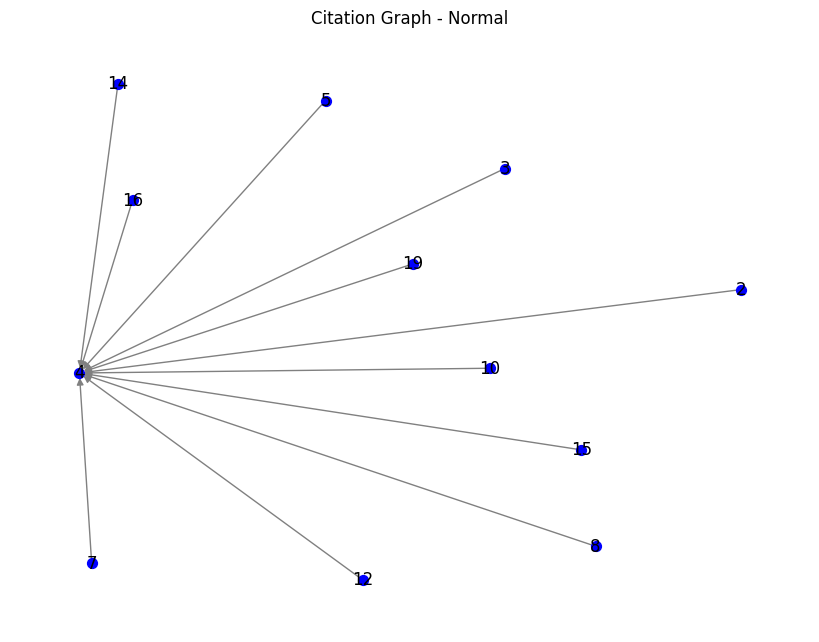

tensor([14])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 14: Not Fraud


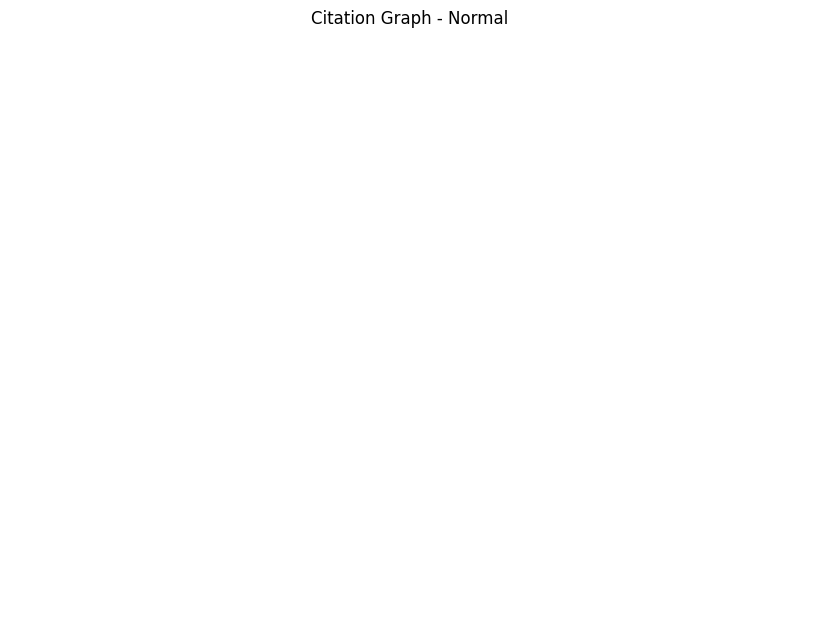

tensor([15])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 15: Not Fraud


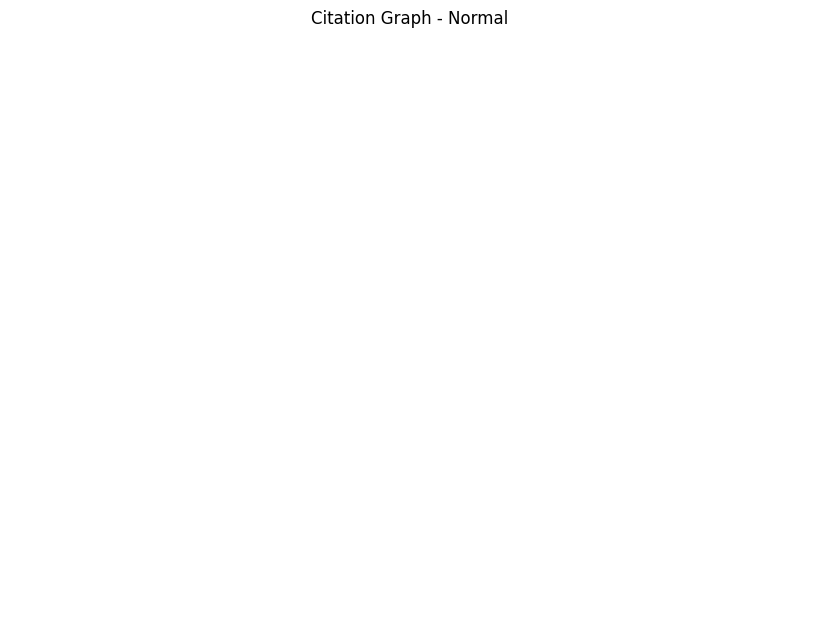

tensor([ 0,  1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 23, 24, 25, 26])
tensor([[ 0,  1,  2,  4,  5,  6,  7,  8,  9, 12, 12, 13, 14, 15, 17, 18, 19, 20,
         20, 21, 21],
        [11, 11, 22, 11, 11, 22, 11, 22, 22, 11, 22, 11, 22, 11, 22, 22, 11, 11,
         22, 11, 22]])
tensor([14])
tensor([False,  True,  True, False, False,  True, False, False, False, False,
         True, False,  True, False, False,  True,  True,  True, False,  True,
        False, False, False, False, False,  True,  True,  True, False,  True,
         True, False, False, False, False, False, False,  True, False,  True,
        False, False,  True,  True, False,  True, False, False,  True,  True,
        False, False])
Fraud Prediction for Node 16: Not Fraud


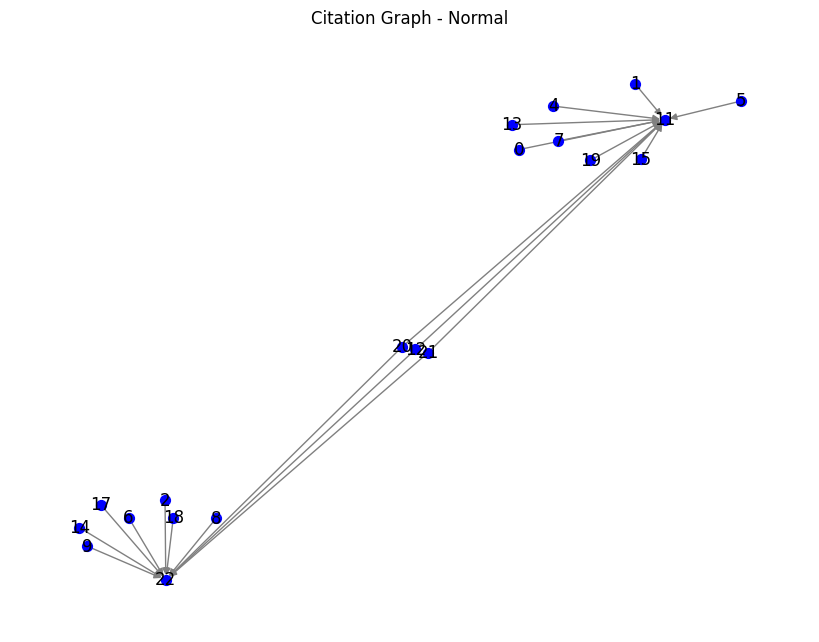

tensor([17])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 17: Not Fraud


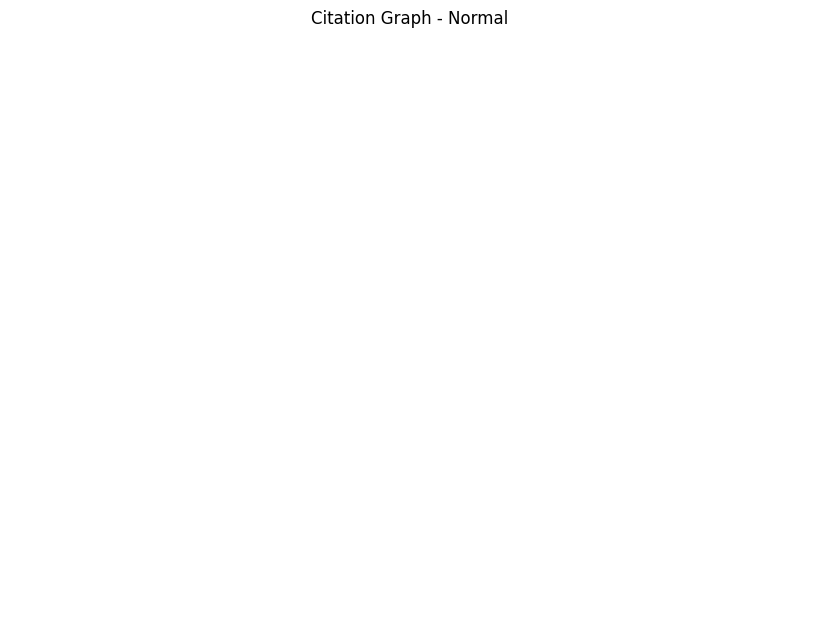

tensor([18])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 18: Fraud


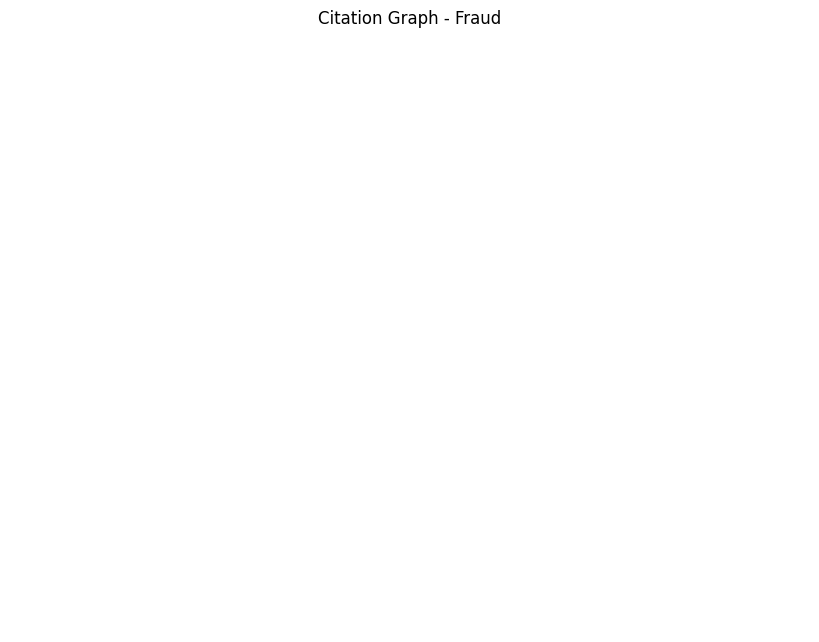

tensor([ 0,  3,  4,  5,  6,  8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 22, 24, 25,
        26])
tensor([[ 0,  2,  4,  5,  5,  6,  7,  9, 10, 12, 13, 14, 15, 16, 17, 17],
        [ 1, 18,  1,  1, 18, 18, 18, 18, 18,  1, 18, 18,  1, 18,  1, 18]])
tensor([13])
tensor([ True, False, False, False, False,  True, False, False, False,  True,
        False, False, False,  True, False,  True, False,  True, False,  True,
        False, False, False, False, False, False,  True, False, False,  True,
        False, False, False,  True, False, False, False,  True, False,  True,
        False,  True, False, False, False,  True,  True, False, False,  True,
        False, False])
Fraud Prediction for Node 19: Not Fraud


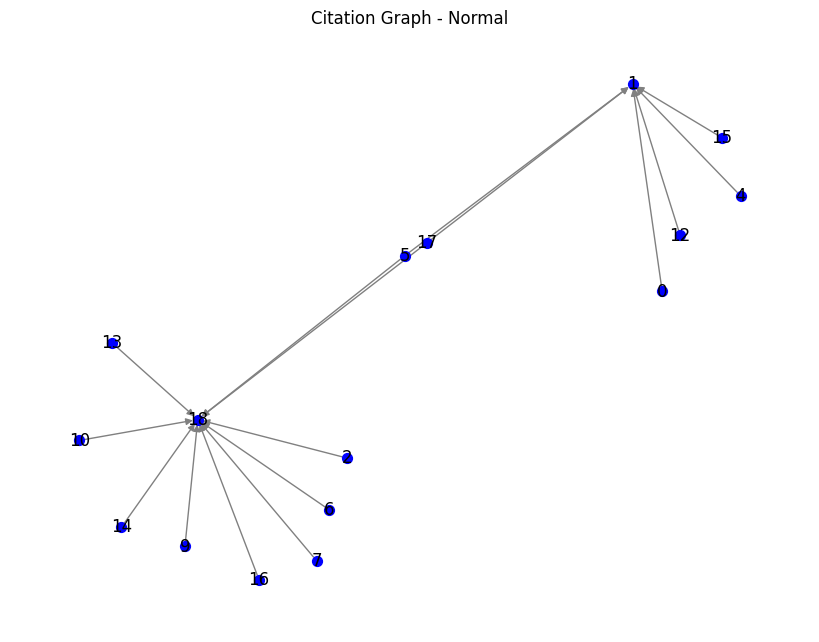

tensor([20])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 20: Not Fraud


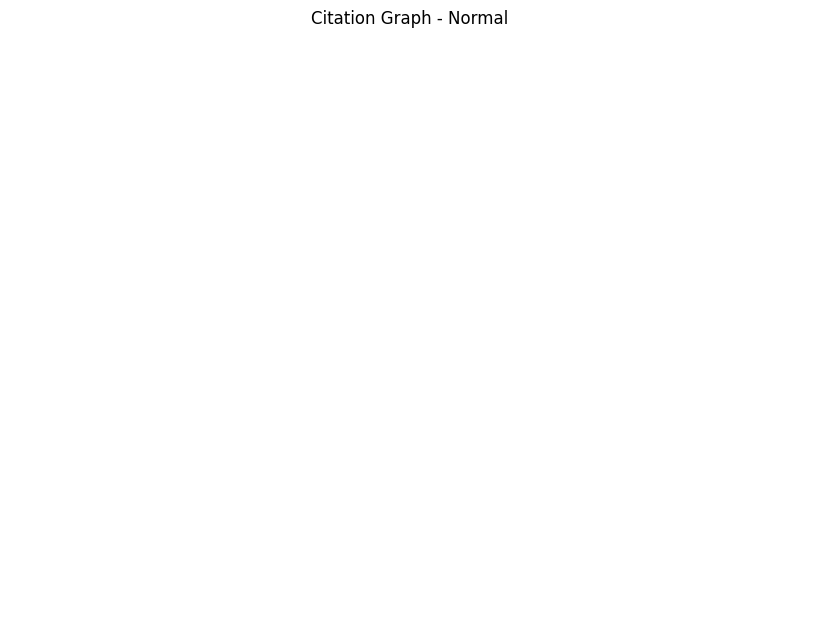

tensor([21])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 21: Not Fraud


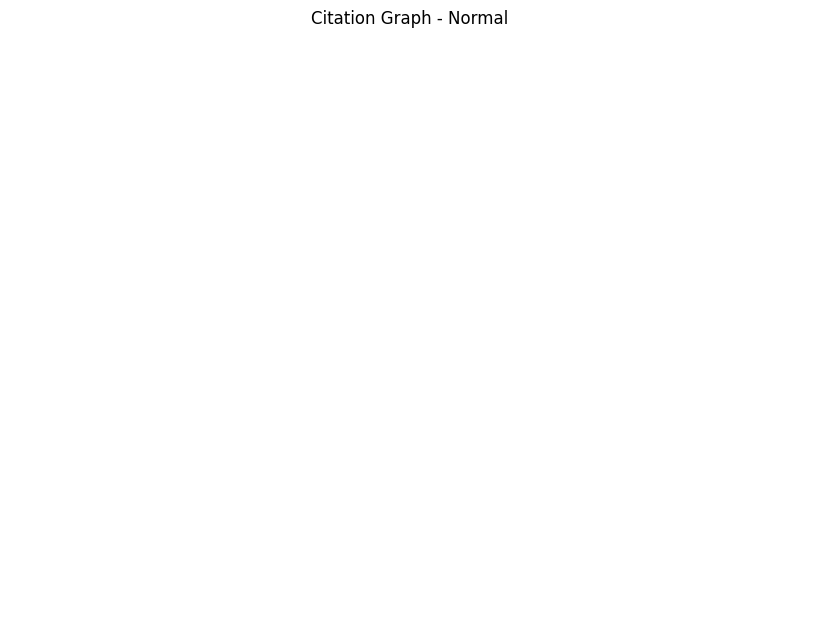

tensor([22])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 22: Not Fraud


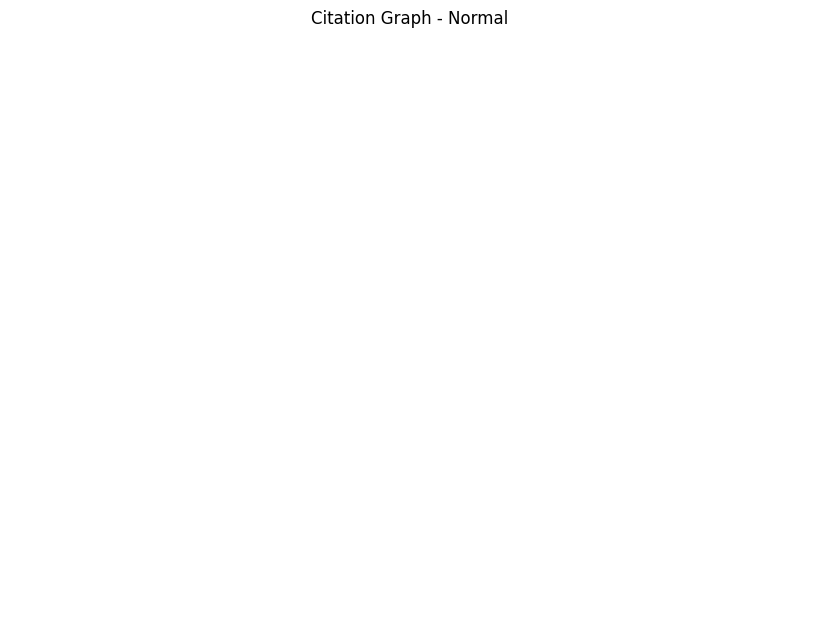

tensor([23])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 23: Not Fraud


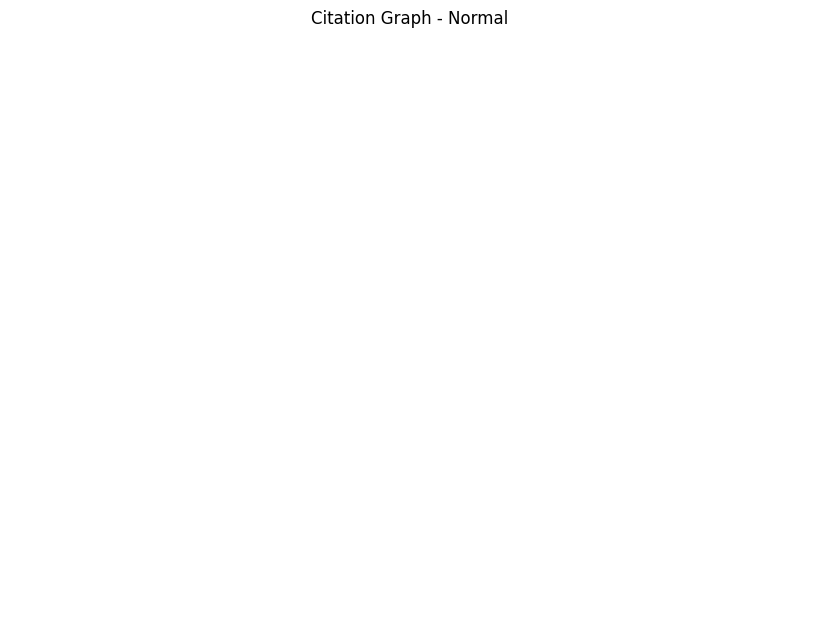

tensor([24])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 24: Fraud


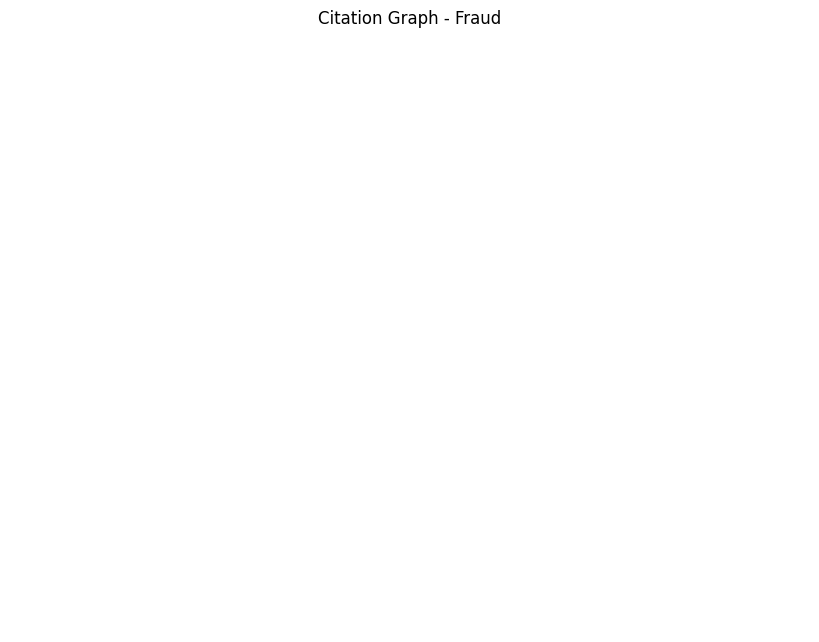

tensor([25])
tensor([], size=(2, 0), dtype=torch.int64)
tensor([0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])
Fraud Prediction for Node 25: Fraud


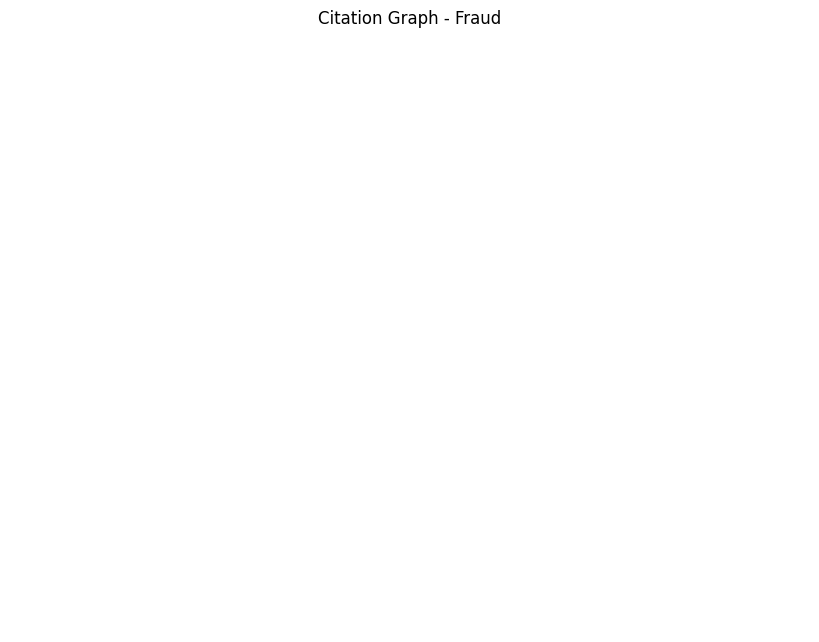

tensor([ 3,  4,  5,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 24, 25, 26])
tensor([[ 0,  2,  2,  3,  6,  6,  7, 10, 10, 11, 13, 14, 16, 16],
        [12,  9, 12,  9,  9, 12,  9,  9, 12,  9,  9,  9,  9, 12]])
tensor([16])
tensor([False, False, False, False,  True, False, False,  True,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
        False,  True,  True,  True, False, False, False, False, False, False,
        False,  True,  True, False, False,  True, False, False,  True, False,
        False, False, False, False,  True, False, False, False, False, False,
         True,  True])
Fraud Prediction for Node 26: Fraud


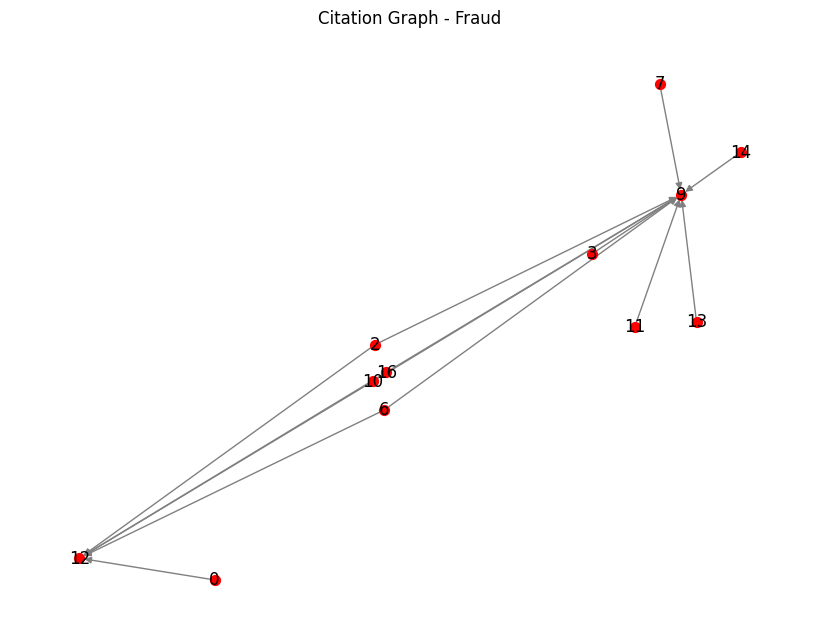

IndexError: index 27 is out of bounds for dimension 0 with size 27

In [102]:
# Example: Analyze fraud in a subgraph around node 5
# analyze_subgraph(model, data_sample, node_idx=5, k=2)
for i in range(30):
  analyze_subgraph(model, data_sample, node_idx=i, k=2)


# Testing

In [6]:
test_dataset = [generate_synthetic_data() for _ in range(200)]
# test_dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [109]:
evaluate_model(model, test_dataset)

Model Accuracy: 0.7000
